In [1]:
%matplotlib inline
import csv
import networkx as nx
import matplotlib.pyplot as plt
import itertools
import collections
import numpy as np
import ast
import pandas as pd
import io
from random import random

# Account clock experiments

- Each account has two sets: Spend Set and Claim Set: 
    + Sets are essentially an array, where each index corresonds to the transaction partner (input or output)
    + Each set value is an aggregate of total balance: total up/ total down
    + Claim set with index zero is minting claim and such claim must be provided with a proof of minting
- Each transaction has link to the two set aggregate. 



## Experiments with clocks

In [6]:
# Auxilary functions
def construct_graph(filename):
    G = nx.Graph()
    with open(filename, "r") as csvfile:
        first = True
        for k in csvfile:
            if first:
                first = False
                continue
            a, b = k.split(",")
            G.add_edge(int(a), int(b))
    return G

    
def query_neighbors(G, p1, pn):
    '''
    p1 queries pn about neighbors of the graph G
    '''
    # Honest answer
    return G[pn]

In [164]:

class State:
    def __init__(self, my_id, neigh_set):
        self.claim_set = {k:0 for k in neigh_set}
        self.spend_set = {k:0 for k in neigh_set}
        self.claim_set[my_id] = 0
    
    def compress(self):
        return (self.claim_set, self.spend_set)

class Peer:
    ''' 
    Partner must have enough balance. For this we need to calculate spends and claims:
      1. All spends must be fullfilled. Nothing should be missed
        - Peer can synchronize with other parties to ensure that. 
        - Depending on the double spending policy, peer must decide what to do if double spending happends.
          Potentially, all spends, including double spends might be accounted. 
          Otherwise peer when detecting can exlude other peer.  
      2. Claims must be valid. A valid claim must fullfill following conditions: 
        - Claim must initally come from a trusted/verified source, either trusted minter, miner, transaction fee, etc.
        - If claim does not come from the peer itself(minting, mining), the previous owner balance must be accountable.
        - If the transaction links to the peer itself, the transaction is valid. 
        - Otherwise the claim has a vector clock of last timestamp. 
          Such timestamp can be used as the verification pointer for the third party. 
          For example, A has a balance estimation for the peer B at timestamp (0, 2, 1, 10). 
          Then if C comes to A with a spend from B that is older than the timestamp, claim of C that is linked to this timestamp is valid. 
        - Peer cannot verify everything directly. A confirmation from at least K near witness would convince peer A.   
    '''
    def __init__(self, my_id, neigh_set, chain_budget=100, peer_budget=10):
        self.my_id = my_id
        self.neigh_set = neigh_set
        self.chain = []
        self.last_neigh_chain = {k:0 for k in neigh_set}
        
        self.state = State(self.my_id, self.neigh_set)
        
        self.incoming_spend_set = {k:0 for k in neigh_set}
        self.verified_balance = {k:[0, None] for k in neigh_set}
        
        self.C_B = chain_budget
        self.P_B = peer_budget

    def balance(self):
        return sum(self.state.claim_set.values()) - sum(self.state.spend_set.values())
    
    def mint(self, num):
        self.state.claim_set[self.my_id] += num
        self.chain.append((self.my_id, num))
    
    def spend(self, par, num):
        self.state.spend_set[par] += num
        self.chain.append((self.my_id, -num))
        
    def random_spend_claim(self, num):
        par = np.random.choice(self.neigh_set)
        self.spend(par, num)        
        peers[par].claim(self.my_id, num)
        return par
    
    def estimate_balance(self, par, spends, claims):
        # Account all spends
        total_spends = sum(spends.values())
        
        # Account claims that are first directly verifiable 
        total_claim = claims[par]
        if self.my_id in claims:
            total_claim+=claims[self.my_id]
        unverified_claims = list()
        
        # Check peer that are known and verified to some extend 
        for k in set(claims.keys())-{self.my_id, par}:
            # TODO: count in timestamps too/ Now it assumes it is recent
            if k in self.verified_balance:
                total_claim += claims[k]
            else:
                if claims[k] > 0:
                    unverified_claims.append(k)
        return (total_claim-total_spends, unverified_claims)
        
    
    def verify_claim(self, par, num):
        if self.incoming_spend_set[par] + num != peers[par].state.spend_set[self.my_id]:
            # Something is wrong, your partner spend more than you recorded 
            print("Not synchronized")
            return False
        
        balance, unverified_claims = self.estimate_balance(par, peers[par].state.spend_set, 
                                                           peers[par].state.claim_set)
        
        if balance >= 0:
            if par not in self.verified_balance:
                self.verified_balance[par] = balance
            return True
        # Otherwise use witnesses/ or download some blocks 
        
        for u_c in unverified_claims:
            #balance+=peers[par].state.claim_set[u_c]
            if self.try_sync(u_c, self.C_B, self.P_B):
                balance+=peers[par].state.claim_set[u_c]
                
        if balance < 0:
            print(self.my_id, par, num)
            print(unverified_claims)
            print("Estimated balance is ", balance)
            return False
        else:
            return True
    
    def try_sync(self, par, K, max_depth):
        # K budget for the synchronization 
        if par not in self.last_neigh_chain:
            self.last_neigh_chain[par] = 0
        if len(peers[par].chain) - self.last_neigh_chain[par] < K:
            # Get the whole chain TODO: fix that
            self.last_neigh_chain[par] = len(peers[par].chain)
            bal, left = self.estimate_balance(par, peers[par].state.spend_set, 
                                                           peers[par].state.claim_set)
            if bal >= 0:
                if par not in self.verified_balance:
                    self.verified_balance[par] = bal
                return True
            else:
                if max_depth < 2:
                    return False
                for un_cl in left:
                    return self.try_sync(un_cl, self.C_B, max_depth-1)
                    
    
    def claim(self, par, num):
        if self.verify_claim(par, num):
            self.incoming_spend_set[par] += num
            self.state.claim_set[par] += num
            self.chain.append((self.my_id, num))
            self.last_neigh_chain[par] =  len(peers[par].chain)
        else: 
            self.incoming_spend_set[par] += num
            print("Will not claim the spend, is not valid")


    

In [166]:
peers[3].verified_balance

{43: [0, None],
 36: [0, None],
 19: [0, None],
 18: [0, None],
 10: [0, None],
 32: [0, None],
 45: [0, None],
 23: [0, None],
 38: [0, None],
 14: [0, None],
 1: 8.36363636363636,
 5: 16.545454545454547,
 31: 4.90909090909091,
 8: 2.603305785123967,
 50: 6.1735537190082646,
 6: 1.4876033057851235,
 37: 3.79338842975206,
 39: 2.9008264462809894,
 16: 1.115702479338843,
 22: 3.3471074380165295,
 40: 4.239669421487601,
 48: 4.1652892561983474,
 49: 8.776859504132227}

In [167]:
peers = {k:Peer(k, list(G[k]), chain_budget=1000, peer_budget=5) for k in G.nodes()}

initial_minters = range(1, 6)
t = 10
tx_size = 9
frontier = []

for k in initial_minters:
    peers[k].mint(100)
    for l in range(t):
        val = peers[k].random_spend_claim(tx_size)
        frontier.append(val)

for h in range(2):
    new_frontier = []
    tx_size /= (t+1)
    for k in frontier:
        for l in range(t):
            val = peers[k].random_spend_claim(tx_size)
            new_frontier.append(val)
    frontier = new_frontier
    
    
    


8 37 0.0743801652892562
[1, 34, 41, 15, 49, 22, 27]
Estimated balance is  -0.37190082644628
Will not claim the spend, is not valid
22 10 0.0743801652892562
[3, 45, 15, 16, 18]
Estimated balance is  -2.008264462809919
Will not claim the spend, is not valid
22 10 0.0743801652892562
[3, 45, 15, 16, 18]
Estimated balance is  -3.3471074380165273
Will not claim the spend, is not valid
22 10 0.0743801652892562
[3, 45, 15, 16, 18]
Estimated balance is  -3.7190082644628095
Will not claim the spend, is not valid
22 10 0.0743801652892562
[3, 45, 15, 16, 18]
Estimated balance is  -3.6446280991735502
Will not claim the spend, is not valid
22 10 0.0743801652892562
[3, 45, 15, 16, 18]
Estimated balance is  -4.314049586776855
Will not claim the spend, is not valid
22 10 0.0743801652892562
[3, 45, 15, 16, 18]
Estimated balance is  -4.834710743801651
Will not claim the spend, is not valid
22 10 0.0743801652892562
[3, 45, 15, 16, 18]
Estimated balance is  -4.9090909090909065
Will not claim the spend, is 

In [125]:
peers[36].last_neigh_chain

{22: 48,
 10: 0,
 3: 6,
 12: 30,
 25: 0,
 15: 0,
 28: 25,
 2: 32,
 5: 53,
 37: 23,
 1: 48,
 32: 16,
 4: 33,
 43: 22,
 45: 35,
 20: 35,
 24: 43,
 9: 35,
 26: 26}

In [120]:
peers[22].balance()

11.454545454545455

In [130]:
vals = peers[36].balance() / 20
for i in range(10):
    print(peers[36].random_spend_claim(vals))
print(peers[36].balance())

10
22
12
15
25
10
28
3
25
3
0.26143465909090935


In [65]:
peers[1].state.compress()

({21: 0,
  5: 1.6363636363636365,
  7: 0,
  11: 0,
  31: 1.6363636363636365,
  10: 0.8181818181818182,
  37: 0.8181818181818182,
  32: 0.8181818181818182,
  9: 7.363636363636364,
  22: 0,
  1: 100},
 {21: 9, 5: 9, 7: 0, 11: 0, 31: 9, 10: 9, 37: 18, 32: 9, 9: 27, 22: 0})

In [41]:
peers[1].state.claim_set

{21: 2.7,
 5: 9.9,
 7: 1.8,
 11: 0,
 31: 0,
 10: 2.7,
 37: 1.8,
 32: 1.8,
 9: 1.8,
 22: 0.9,
 1: 100}

{773: 0,
 263: 0,
 906: 0,
 397: 0,
 398: 0,
 911: 0,
 141: 0,
 142: 0,
 535: 0,
 152: 0,
 412: 0,
 311: 0,
 825: 0,
 186: 0,
 828: 0,
 846: 0,
 595: 0,
 731: 0,
 861: 0,
 990: 0,
 608: 0,
 868: 0,
 109: 0,
 370: 0,
 249: 0,
 634: 0,
 102: 100}

### Create an interaction network

50


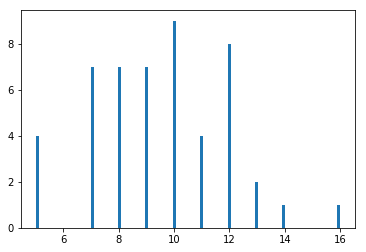

In [7]:
# initialize peers/ Create and Overlay network  
N = 100
G = construct_graph("GraphDynamics/peer_connections.log.txt")
# Discovery community after 210 seconds 
print(G.number_of_nodes())
x = sorted([d for n, d in G.degree()], reverse=True)

fig = plt.figure()
ax = fig.add_subplot(111)
n, bins, rectangles = ax.hist(x, 100, density=False)
fig.canvas.draw()
plt.show()




### Initialize clocks and peers

In [ ]:


for p in G.nodes():
    for n in neigh
    neigh = G[p]
    
    